# 모델 생성
- 앞에 선택한 데이터들을 이용하여 전력량을 예측하는 모델을 생성
- 독립변수 : 지역코드, 최저기온(°C), 3.0m 지중온도(°C), 평균 현지기압(hPa), 가조시간(hr), 평균 상대습도(%), 풍정합(100m), 합계 소형증발량(mm)
- 타겟변수 : 파워 (전력량)

In [1]:
import tensorflow as tf
print("텐서플로우 버전:", tf.__version__)

from tensorflow.keras.layers import Dense, Dropout, Input
print("Keras 임포트 성공!")

텐서플로우 버전: 2.10.0
Keras 임포트 성공!


## 모델 생성을 위한 훈련데이터

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

In [3]:
df = pd.read_csv('../data/훈련데이터셋/1_훈련데이터셋_날짜미포함.csv')
df.head(1)

,지역코드,최저기온(°C),0.5m 지중온도(°C),평균 증기압(hPa),가조시간(hr),평균 상대습도(%),파워
0,1111010100,-5.2,7.5,1.8,9.7,38.9,146294.6135


### 데이터셋을 train, test로 나누기

In [4]:
X = df.drop(columns='파워')
y = df['파워']
X.shape, y.shape

((181408, 6), (181408,))

In [5]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((145126, 6), (36282, 6), (145126,), (36282,))

### 훈련데이터 전처리
- 지역코드는 원핫인코딩 처리
- 나머지는 정규화 처리

행 당 한개의 정규화 모델을 만들기에는 너무 많은 정규화 모델이 만들어지고 이를 하나하나 다 저장하기에는 힘들기에 sklear의 ColumnTransformer를 사용

In [6]:
preprocessor = ColumnTransformer(
    transformers=[('onehot', OneHotEncoder(), ['지역코드']), 
                ('standardScaler', StandardScaler(), [col for col in X.columns if col!='지역코드'])]
    )

In [7]:
X_train_preprocessed = preprocessor.fit_transform(X_train)

In [ ]:
# 전처리 모델 저장하기
import joblib
import os
path = 'SimpleDNN_날짜미포함/'
if not os.path.exists(path):
    os.mkdir(path)
joblib.dump(preprocessor, path+'preprocessor.joblib')

['preprocessor.joblib']

## 모델 생성 (DNN)

### 간단한 모델
- 간단한 모델 하나를 만들어 훈련시간과 결과를 보기

In [9]:
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [10]:
X_train_preprocessed.toarray().shape, y_train.shape

((145126, 471), (145126,))

In [11]:
model = Sequential()
model.add(Input(X_train_preprocessed.shape[1],))
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1, activation='relu'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               241664    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2

In [ ]:
import os
earlyStop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

filename = 'DNN{epoch:03d}_loss_{val_loss:.4f}.h5'
checkpoint = ModelCheckpoint(filepath=path+filename, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])

hist = model.fit(X_train_preprocessed.toarray(), y_train, callbacks=[earlyStop, checkpoint], validation_split=0.2, epochs=100, verbose=1)

Epoch 1/100
3629/3629 [==============================] - 13s 3ms/step - loss: 55193448448.0000 - mae: 54076.7031 - mse: 55193448448.0000 - val_loss: 45956780032.0000 - val_mae: 44170.9336 - val_mse: 45956780032.0000
Epoch 2/100
3629/3629 [==============================] - 12s 3ms/step - loss: 39766974464.0000 - mae: 37190.8633 - mse: 39766974464.0000 - val_loss: 36422356992.0000 - val_mae: 32663.6934 - val_mse: 36422356992.0000
Epoch 3/100
3629/3629 [==============================] - 12s 3ms/step - loss: 38218547200.0000 - mae: 35344.6289 - mse: 38218547200.0000 - val_loss: 38345478144.0000 - val_mae: 30221.4805 - val_mse: 38345478144.0000
Epoch 4/100
3629/3629 [==============================] - 12s 3ms/step - loss: 38431805440.0000 - mae: 34731.5469 - mse: 38431805440.0000 - val_loss: 34777858048.0000 - val_mae: 29881.2422 - val_mse: 34777858048.0000
Epoch 5/100
3629/3629 [==============================] - 12s 3ms/step - loss: 38975434752.0000 - mae: 34249.2930 - mse: 38975434752.0000

In [13]:
# 테스트 해보기
# X_test_preprocessor = preprocessor.transform(X_test)
# test_loss, test_mae, test_mse = model.evaluate(X_test_preprocessor.toarray(), y_test, verbose=0)
# print(f"\nTest Results:")
# print(f"  MSE: {test_mse:.2f}")
# print(f"  MAE: {test_mae:.2f}")
# print(f"  RMSE: {np.sqrt(test_mse):.2f}")
import numpy as np

def evaluate_model(model, preprocessor, X_test, y_test, model_name):
    X_test_prep = preprocessor.transform(X_test)

    test_loss, test_mae, test_mse = model.evaluate(
        X_test_prep.toarray(),
        y_test,
        verbose=0
    )

    rmse = np.sqrt(test_mse)

    print(f"\n[Test Results - {model_name}]")
    print(f"  MSE : {test_mse:.4f}")
    print(f"  MAE : {test_mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")

    return {
        "model": model_name,
        "mse": float(test_mse),
        "mae": float(test_mae),
        "rmse": float(rmse),
        "n_test": len(y_test)
    }


In [ ]:
import os
import json
from datetime import datetime

def save_result_json(result: dict, filename: str):
    result = dict(result)  # 안전 복사
    result["saved_at"] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    with open(filename, "w", encoding="utf-8") as f:
        json.dump(result, f, ensure_ascii=False, indent=2)

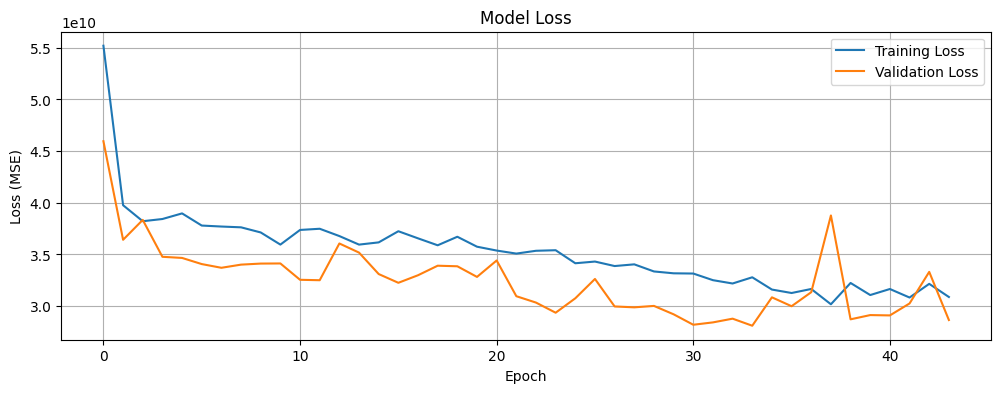

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Model Loss')
plt.legend()
plt.grid(True)

In [ ]:
# 마지막 모델 테스트
res = evaluate_model(
    model=model,
    preprocessor=preprocessor,
    X_test=X_test,
    y_test=y_test,
    model_name="SimpleDNN (날짜 미포함)"
)





[Test Results - DNN (날짜 미포함)]
  MSE : 26276315136.0000
  MAE : 25853.3457
  RMSE: 162099.7074


In [ ]:
# 가장 마지막에 저장된 모델 (MSE가 가장 낮은 모델) 테스트
# 마지막 저장된 모델 외에는 삭제를 할 예정이기에 실행시 에러가 나는게 정상입니다
model1 = load_model(path+'DNN031_loss_28204427264.0000.h5')
res1 = evaluate_model(
    model=model1,
    preprocessor=preprocessor,
    X_test=X_test,
    y_test=y_test,
    model_name="SimpleDNN (날짜 미포함)"
)


[Test Results - DNN (날짜 미포함)]
  MSE : 25964318720.0000
  MAE : 26203.8340
  RMSE: 161134.4740


In [ ]:
# 마지막 모델과 MSE가 가장 낮은 모델의 예측값을 비교해본 결과 MAE가 더 작은 마지막 모델을 저장
save_result_json(res, path+"result.json")
save_model(model, path+"final_model.h5")